**ADS 504 - Final Project**

**Team #1:** Liam Richardson, Matt Ammirati, Lorena Dorado

**Link to GitHub:** [https://github.com/renaqd/team1-ADS505](https://github.com/renaqd/team1-ADS505)

**Date:** October 14, 2024

**Introduction**

This project uses a several dataset containing 1,094,411 user reviews from Sephora.com. Only skincare products are available.

Using machine learning and statistical analysis, the team (Liam, Matt, and Lorena) seek to create a personalized recommendation engine, identify candidate products for promotion, and understand customer segments in order to better inform our marketing efforts. To achieve this objective, we will cluster and identify products that are prime candidates for promotion through our robust recommendation system.

# Identifying products which are prime candidates for promotion 

## Liam Richardson

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import norm
from scipy.stats import percentileofscore


In [2]:
df0=pd.read_csv("Business_Final_Project/reviews_0-250.csv")
df1=pd.read_csv("Business_Final_Project/reviews_250-500.csv")
df2=pd.read_csv("Business_Final_Project/reviews_500-750.csv")
df3=pd.read_csv("Business_Final_Project/reviews_750-1250.csv")
df4=pd.read_csv("Business_Final_Project/reviews_1250-end.csv")
df_li = pd.concat([df0,df1, df2, df3, df4], axis=0) 
grouped_df = df_li.groupby('product_id').agg(
    avg_review=('rating', 'mean'),
    review_title_count=('review_title', 'count')
).reset_index()


C:\Users\oliwa\AppData\Local\Temp\ipykernel_16912\3880438555.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df0=pd.read_csv("Business_Final_Project/reviews_0-250.csv")
C:\Users\oliwa\AppData\Local\Temp\ipykernel_16912\3880438555.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df3=pd.read_csv("Business_Final_Project/reviews_750-1250.csv")
C:\Users\oliwa\AppData\Local\Temp\ipykernel_16912\3880438555.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df4=pd.read_csv("Business_Final_Project/reviews_1250-end.csv")


In [3]:
zscore_review_threshold=(50-(grouped_df['review_title_count'].std()))/grouped_df['review_title_count'].mean()
zscore_rating_threshold=(5-(df_li['rating'].std()))/df_li['rating'].mean()

percent_review = norm.cdf(zscore_review_threshold) * 100
percent_rating = norm.cdf(zscore_rating_threshold) * 100

# Print the results
print(f"Based on the z score for reviews=50 this threshold represents only {percent_review:.2f}% of products.")
print(f"Based on the z_score of rating=5 this threshold represents {percent_rating:.2f}% of products.")

Based on the z score for reviews=50 this threshold represents only 3.64% of products.
Based on the z_score of rating=5 this threshold represents 81.48% of products.


###### Apply filters to keep only low reviewed, high ranking products, convert review text to bag of words representation

In [4]:


filtered_df = grouped_df[(grouped_df['avg_review'] > 4.9) & 
                         (grouped_df['review_title_count'] > 20) & 
                         (grouped_df['review_title_count'] < 50)]
underrepresented=filtered_df['product_id']
char_df = df_li[df_li['product_id'].isin(underrepresented)]
char_df=char_df.dropna(subset=['review_text']) 

## convert review text to bag of words representation 
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3)) #stop words are common connector words "if then but" etc
bag_of_words = vectorizer.fit_transform(char_df['review_text'])

###### Look at top 20 three word combinations left in reviews for filtered products

In [5]:
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())
bow_df['product_id'] = filtered_df['product_id'].reset_index(drop=True)
#Group by 'product_id' and sum up 3-word phrase counts
grouped_bow_df = bow_df.groupby('product_id').sum()
#For each product_id, find the top 10 most common 3-word phrases
def get_top_n_phrases(row, n=20):
    top_phrases = row.sort_values(ascending=False).head(n).index
    return pd.Series(top_phrases, index=[f'most_common_phrase_{i+1}' for i in range(n)])
#Apply the function to get the top 10 3-word phrases for each product_id
top_phrases_df = grouped_bow_df.apply(get_top_n_phrases, axis=1).reset_index()

n = 20  

# Print top 20 3 word combos per product ID
for index, row in top_phrases_df.iterrows():
    print(f"Product ID: {row['product_id']}")
    for i in range(1, n + 1):
        print(f"Most common word {i}: {row[f'most_common_phrase_{i}']}")
    print("="*30) 

merged_df = filtered_df.merge(df_li[['product_id', 'product_name','brand_name']], on='product_id', how='left') ## to get product & brand info back
merged_df_unq = merged_df.drop_duplicates(subset='product_id')
merged_df_unq.loc[:, 'avg_review'] = merged_df_unq['avg_review'].round(2)
merged_df_unq = merged_df_unq.rename(columns={'review_title_count': 'number_of_reviews'})

Product ID: P419466
Most common word 1: right time just
Most common word 2: just wonter skincare
Most common word 3: usual packaging cute
Most common word 4: iss perfect size
Most common word 5: skincare routine hydrating
Most common word 6: use winter time
Most common word 7: oil right time
Most common word 8: face oil use
Most common word 9: oil iss perfect
Most common word 10: cute oil iss
Most common word 11: face oil right
Most common word 12: perfect size face
Most common word 13: time just wonter
Most common word 14: hydrating soothing usual
Most common word 15: routine hydrating soothing
Most common word 16: size face oil
Most common word 17: packaging cute oil
Most common word 18: oil use winter
Most common word 19: wonter skincare routine
Most common word 20: soothing usual packaging
Product ID: P476676
Most common word 1: definitely best combo
Most common word 2: 40 skin getting
Most common word 3: impressed product time
Most common word 4: mara skincare definitely
Most comm

In [6]:
merged_df_unq

,product_id,avg_review,number_of_reviews,product_name,brand_name
0,P419466,4.95,43,Tan Build Up Remover Mitt,St. Tropez
59,P476676,4.96,28,Youth Reformer Firming Vitamin C Oil Serum,FaceGym
112,P504016,4.95,46,Mini Evening Primrose + Green Tea Algae Retino...,MARA
190,P504031,4.95,46,Evening Primrose + Green Tea Algae Retinol Fac...,MARA
268,P505133,4.93,35,High Performance Face Cleanser for Clear Skin ...,MACRENE actives
323,P505316,4.93,42,Aquarius BHA + Blue Tansy Clarity Cleanser,Herbivore


## Matt Ammirati

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


In [133]:
%config Completer.use_jedi = False

In [134]:


product_info_df = pd.read_csv('/Users/mattammirati/Desktop/Matts505FinalProject/datasets/product_info (1).csv')

In [135]:
csv_folder = '/Users/mattammirati/Downloads'

# List of file names
csv_files = [
    'reviews_0-250.csv',
    'reviews_250-500.csv',
    'reviews_500-750.csv',
    'reviews_750-1250.csv',
    'reviews_1250-end.csv'
]


csv_files = [os.path.join(csv_folder, file) for file in csv_files]

# Read and concatenate all CSV files
combined_reviews_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)




/var/folders/pl/4pny6kms2p307m4vtyh01smr0000gn/T/ipykernel_43513/471121369.py:16: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_reviews_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
/var/folders/pl/4pny6kms2p307m4vtyh01smr0000gn/T/ipykernel_43513/471121369.py:16: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_reviews_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
/var/folders/pl/4pny6kms2p307m4vtyh01smr0000gn/T/ipykernel_43513/471121369.py:16: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_reviews_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)


In [136]:
combined_reviews_df.shape


(1094411, 19)

In [137]:
product_info_df.shape

(8494, 27)

In [138]:
product_info_df.head(5)

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scent', 'Woody & Earthy Scent', 'Fresh Scent']",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Warm &Spicy Scent']",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Woody & Earthy Scent']",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Warm &Spicy Scent']",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent', 'Woody & Earthy Scent']",Fragrance,Women,Perfume,2,75.0,30.0


In [139]:
pd.set_option('display.max_columns', 10)

# Display the first 5 rows
combined_reviews_df.head()

# Reset the option back to default if needed
pd.reset_option('display.max_columns')

In [140]:
combined_reviews_df.columns

Index(['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

In [141]:
product_info_df.columns

Index(['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count',
       'rating', 'reviews', 'size', 'variation_type', 'variation_value',
       'variation_desc', 'ingredients', 'price_usd', 'value_price_usd',
       'sale_price_usd', 'limited_edition', 'new', 'online_only',
       'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category',
       'secondary_category', 'tertiary_category', 'child_count',
       'child_max_price', 'child_min_price'],
      dtype='object')

In [142]:
product_info_df.isnull().sum()

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

In [143]:
combined_reviews_df.isnull().sum()

Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name                     0
brand_name                       0
price_usd                        0
dtype: int64

<b>Start the cleaning process</b>

In [144]:
#impute where it makes sense with random values, drop the helpfullness column because too many missing values
#use the mode for the binary is recommended.
cleaned_combined_reviews = combined_reviews_df
cleaned_combined_reviews['review_text'] = combined_reviews_df['review_text'].fillna('No Review')
cleaned_combined_reviews = combined_reviews_df.drop(columns=['helpfulness'])
cleaned_combined_reviews['is_recommended'] = combined_reviews_df['is_recommended'].fillna(combined_reviews_df['is_recommended'].mode()[0])
cleaned_combined_reviews['review_title'] = combined_reviews_df['review_title'].fillna('No Title')
cleaned_combined_reviews['skin_tone'] = combined_reviews_df['skin_tone'].fillna('Unknown')
cleaned_combined_reviews['eye_color'] = combined_reviews_df['eye_color'].fillna('Unknown')
cleaned_combined_reviews['skin_type'] = combined_reviews_df['skin_type'].fillna('Unknown')
cleaned_combined_reviews['hair_color'] = combined_reviews_df['hair_color'].fillna('Unknown')


In [145]:
cleaned_combined_reviews.isnull().sum()

Unnamed: 0                  0
author_id                   0
rating                      0
is_recommended              0
total_feedback_count        0
total_neg_feedback_count    0
total_pos_feedback_count    0
submission_time             0
review_text                 0
review_title                0
skin_tone                   0
eye_color                   0
skin_type                   0
hair_color                  0
product_id                  0
product_name                0
brand_name                  0
price_usd                   0
dtype: int64

<b>Use this cleaned data frame to pull the data that we need to identify common good factors and common bad factors</b>

In [146]:
# Define good and bad reviews
cleaned_combined_reviews['review_category'] = cleaned_combined_reviews['rating'].apply(
    lambda x: 'good' if x >= 4 else ('bad' if x <= 2 else 'neutral')
)

# Separate the data into good and bad reviews
good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'good']
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'bad']
20

20

In [147]:
# Summary for good reviews by price summary stats
print(good_reviews[['price_usd']].describe())

# Summary for bad reviews by price summary stats
print(bad_reviews[['price_usd']].describe())

           price_usd
count  898340.000000
mean       49.227741
std        39.637330
min         3.000000
25%        26.000000
50%        39.000000
75%        64.000000
max      1900.000000
           price_usd
count  114255.000000
mean       46.735717
std        41.719211
min         3.000000
25%        24.000000
50%        38.000000
75%        58.000000
max      1900.000000


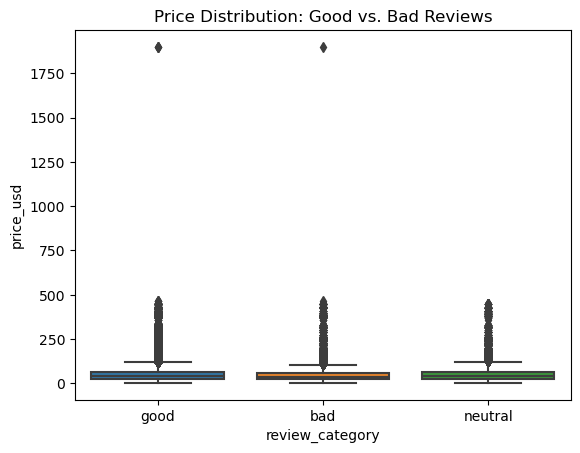

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Price comparison between good and bad reviews
sns.boxplot(x='review_category', y='price_usd', data=cleaned_combined_reviews)
plt.title('Price Distribution: Good vs. Bad Reviews')
plt.show()

Price alone does not seem to be a strong factor in determining whether a product gets good or bad reviews, as the price distributions for all categories are very similar.

<b>To Further determine Good or bad factors with in the reviewed data, perform sentiment analysis on the text data.</b>

In [149]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattammirati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [150]:
from textblob import TextBlob

# Apply sentiment analysis - assign a polarity value from the review_text column
cleaned_combined_reviews['sentiment'] = cleaned_combined_reviews['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Recreate good and bad reviews after the sentiment column is added
good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['rating'] > 3]
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['rating'] <= 3]

# Compare sentiment for good and bad reviews
print("Average Sentiment for Good Reviews:", good_reviews['sentiment'].mean())
print("Average Sentiment for Bad Reviews:", bad_reviews['sentiment'].mean())


Average Sentiment for Good Reviews: 0.26867698719464767
Average Sentiment for Bad Reviews: 0.09995091820932907


In [151]:
cleaned_combined_reviews.columns

Index(['Unnamed: 0', 'author_id', 'rating', 'is_recommended',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd',
       'review_category', 'sentiment'],
      dtype='object')

In [152]:
cleaned_combined_reviews.isnull().sum()

Unnamed: 0                  0
author_id                   0
rating                      0
is_recommended              0
total_feedback_count        0
total_neg_feedback_count    0
total_pos_feedback_count    0
submission_time             0
review_text                 0
review_title                0
skin_tone                   0
eye_color                   0
skin_type                   0
hair_color                  0
product_id                  0
product_name                0
brand_name                  0
price_usd                   0
review_category             0
sentiment                   0
dtype: int64

In [153]:
cleaned_combined_reviews['sentiment'].head(5)

0    0.283333
1    0.000000
2    0.102778
3    0.381250
4   -0.127381
Name: sentiment, dtype: float64

In [154]:
# Split the data into good and bad reviews
good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'good']
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'bad']

# Calculate and print the average sentiment for good reviews
average_good_sentiment = good_reviews['sentiment'].mean()
print("Average Sentiment for Good Reviews:", average_good_sentiment)

# Calculate and print the average sentiment for bad reviews
average_bad_sentiment = bad_reviews['sentiment'].mean()
print("Average Sentiment for Bad Reviews:", average_bad_sentiment)


Average Sentiment for Good Reviews: 0.26867698719464767
Average Sentiment for Bad Reviews: 0.048060889174157795


/Users/mattammirati/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mattammirati/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


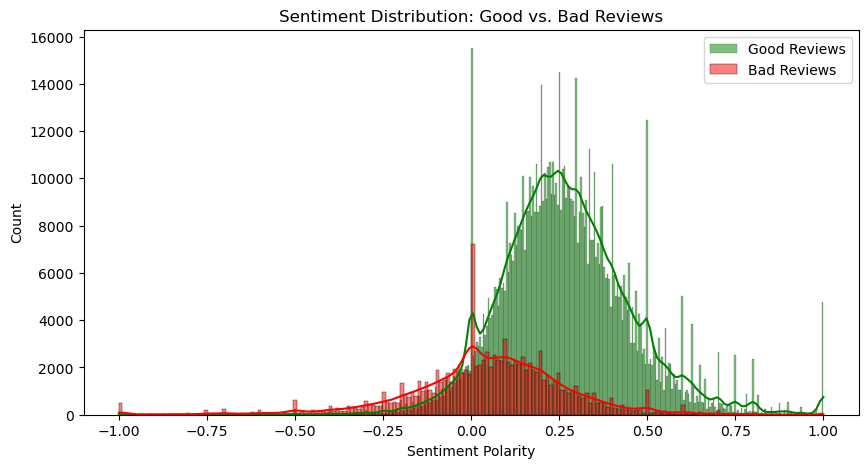

In [155]:
plt.figure(figsize=(10,5))
sns.histplot(good_reviews['sentiment'], color='green', label='Good Reviews', kde=True)
sns.histplot(bad_reviews['sentiment'], color='red', label='Bad Reviews', kde=True)
plt.title('Sentiment Distribution: Good vs. Bad Reviews')
plt.xlabel('Sentiment Polarity')
plt.legend()
plt.show()

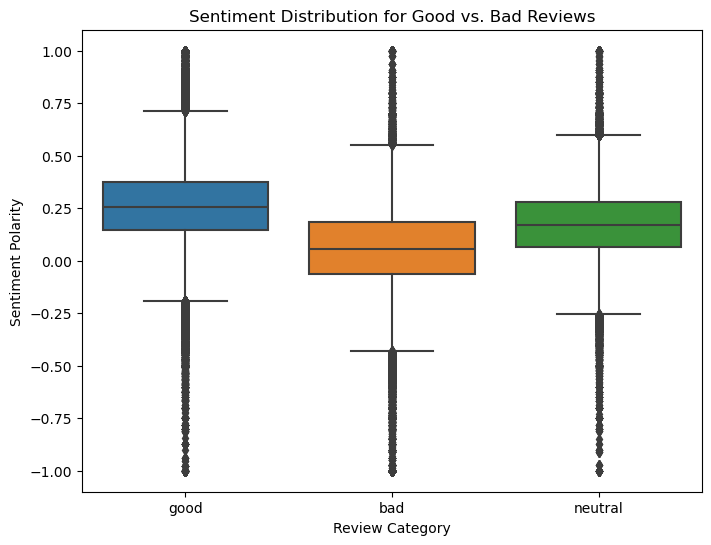

In [156]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='review_category', y='sentiment', data=cleaned_combined_reviews)
plt.title('Sentiment Distribution for Good vs. Bad Reviews')
plt.xlabel('Review Category')
plt.ylabel('Sentiment Polarity')
plt.show()


Based on our sentiment analysis, this means that there is average sentiment for good and bad reviews. Essentially this means that there isn't extraordinary language used on the good reviews or bad. They are mild reviews in both cases.  The range is -1 bad sentiment to positive 1 good sentiment. Since the sentiment for bad reviews is .04 that means that even the bad reviews are leaning towards neutral rather than bad. 

To further gather insight from the review_text category, keyword analysis will be used

In [157]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Download stopwords from NLTK if necessary
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean the text (remove special characters, stopwords, and lowercase everything)
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the 'review_text' column
cleaned_combined_reviews['cleaned_review_text'] = cleaned_combined_reviews['review_text'].apply(clean_text)

# Separate good and bad reviews based on the 'review_category' column
good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'good']
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'bad']

# Define the vectorizer to get unigrams, bigrams, and trigrams or single words, 2 word and three word scenarios
vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', max_features=100)  # Adjust max_features as needed

# Apply the vectorizer separately to good and bad reviews
good_phrases = vectorizer.fit_transform(good_reviews['cleaned_review_text']).toarray()
bad_phrases = vectorizer.fit_transform(bad_reviews['cleaned_review_text']).toarray()

# Get the vocabulary (most common words/phrases)
good_feature_names = vectorizer.get_feature_names_out()
bad_feature_names = vectorizer.get_feature_names_out()

#Count the frequency of each phrase for good and bad reviews
good_phrase_counts = good_phrases.sum(axis=0)  # Sum of each phrase's occurrence in good reviews
bad_phrase_counts = bad_phrases.sum(axis=0)  # Sum of each phrase's occurrence in bad reviews

#Create a DataFrame to compare phrases between good and bad reviews
phrase_comparison_df = pd.DataFrame({
    'phrase': good_feature_names,
    'good_reviews_count': good_phrase_counts,
    'bad_reviews_count': bad_phrase_counts
})

# Calculate the difference between how common the phrase is in good vs. bad reviews
phrase_comparison_df['difference'] = phrase_comparison_df['good_reviews_count'] - phrase_comparison_df['bad_reviews_count']

# Sort the phrases based on the difference in frequency
phrase_comparison_df = phrase_comparison_df.sort_values(by='difference', ascending=False)

# Display the most common phrases in good and bad reviews, and the difference in frequency
print("Top 10 Phrases More Common in Good Reviews:")
print(phrase_comparison_df.head(10))

print("\nTop 10 Phrases More Common in Bad Reviews:")
print(phrase_comparison_df.tail(10))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattammirati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 Phrases More Common in Good Reviews:
          phrase  good_reviews_count  bad_reviews_count  difference
80         super             1090209               6865     1083344
65     recommend              528959               9115      519844
49          mask              382918               6903      376015
92        wanted              335574              12456      323118
21      dry skin              280928               6856      274072
41          lips              275132               7054      268078
94         wasnt              255501               5326      250175
67       results              235099               5976      229123
33           got              190730              11780      178950
17  disappointed              186433               7898      178535

Top 10 Phrases More Common in Bad Reviews:
      phrase  good_reviews_count  bad_reviews_count  difference
62  products               55020              14159       40861
11     cream               52703    

Do the same for phrases

In [158]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Download stopwords from NLTK
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the 'review_text' column
cleaned_combined_reviews['cleaned_review_text'] = cleaned_combined_reviews['review_text'].apply(clean_text)

# Separate good and bad reviews based on the 'review_category' column
good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'good']
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'bad']

vectorizer = CountVectorizer(ngram_range=(3, 4), stop_words='english', max_features=100)  # Adjust max_features as needed

# Apply the vectorizer separately to good and bad reviews
good_phrases = vectorizer.fit_transform(good_reviews['cleaned_review_text']).toarray()
good_feature_names = vectorizer.get_feature_names_out()

bad_phrases = vectorizer.fit_transform(bad_reviews['cleaned_review_text']).toarray()
bad_feature_names = vectorizer.get_feature_names_out()

good_phrase_counts = good_phrases.sum(axis=0)  # Sum of each phrase's occurrence in good reviews
bad_phrase_counts = bad_phrases.sum(axis=0)  # Sum of each phrase's occurrence in bad reviews

#different df for different review features
good_phrase_df = pd.DataFrame({
    'phrase': good_feature_names,
    'count': good_phrase_counts
})

bad_phrase_df = pd.DataFrame({
    'phrase': bad_feature_names,
    'count': bad_phrase_counts
})

# Sort phrases by frequency
good_phrase_df = good_phrase_df.sort_values(by='count', ascending=False)
bad_phrase_df = bad_phrase_df.sort_values(by='count', ascending=False)

# Display
print("Top 10 Phrases in Good Reviews:")
print(good_phrase_df.head(20))

print("\nTop 10 Phrases in Bad Reviews:")
print(bad_phrase_df.head(20))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattammirati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 Phrases in Good Reviews:
                            phrase  count
20                   goes long way  35504
40                little goes long  27163
41            little goes long way  26358
33             leaves skin feeling  18368
46                 makes skin feel  17891
65  received product complimentary  16715
68           received product free  16026
1                  acne prone skin  12399
14          exchange honest review  11037
43                  love love love   8125
76               skin care routine   7532
37               left skin feeling   6220
13              dry sensitive skin   6096
84               skin feeling soft   5963
48                 makes skin look   5959
22        highly recommend product   5959
0          absolutely love product   5599
87                 skin feels soft   5469
30              leave skin feeling   5393
26               ive using product   5118

Top 10 Phrases in Bad Reviews:
                            phrase  count
65          

<b>The above shows the most common phrases in good and bad, next connect them to the corresponding product.</b>

In [ ]:


# Clean again
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

cleaned_combined_reviews['cleaned_review_text'] = cleaned_combined_reviews['review_text'].apply(clean_text)

vectorizer = CountVectorizer(ngram_range=(3, 4), stop_words='english', max_features=100)

all_phrases = vectorizer.fit_transform(cleaned_combined_reviews['cleaned_review_text']).toarray()
feature_names = vectorizer.get_feature_names_out()

phrase_df = pd.DataFrame(all_phrases, columns=feature_names)
cleaned_combined_reviews = pd.concat([cleaned_combined_reviews, phrase_df], axis=1)

# Here is where they are grouped with their corresponding product
product_phrases = cleaned_combined_reviews.groupby('product_name')[feature_names].sum()

good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'good']
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'bad']

good_product_phrases = good_reviews.groupby('product_name')[feature_names].sum()
bad_product_phrases = bad_reviews.groupby('product_name')[feature_names].sum()

#display
print("Most Common Good Review Phrases for Each Product:")
print(good_product_phrases.head(10))

print("\nMost Common Bad Review Phrases for Each Product:")
print(bad_product_phrases.head(10))



<b> Most Common Reviews per product </b>

In [ ]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

# Function to clean the text
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning function
cleaned_combined_reviews['cleaned_review_text'] = cleaned_combined_reviews['review_text'].apply(clean_text)

# Vectorizer to extract n-grams
vectorizer = CountVectorizer(ngram_range=(3, 4), stop_words='english', max_features=100)

# Transform the cleaned text into n-gram counts
all_phrases = vectorizer.fit_transform(cleaned_combined_reviews['cleaned_review_text']).toarray()
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for the n-gram phrases
phrase_df = pd.DataFrame(all_phrases, columns=feature_names)

# Concatenate the n-gram phrases with the original DataFrame
cleaned_combined_reviews = pd.concat([cleaned_combined_reviews, phrase_df], axis=1)

# Group the data by product name
product_phrases = cleaned_combined_reviews.groupby('product_name')[feature_names].sum()

# Filter reviews by category (good and bad)
good_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'good']
bad_reviews = cleaned_combined_reviews[cleaned_combined_reviews['review_category'] == 'bad']

# Group by product name and sum the n-grams for good and bad reviews
good_product_phrases = good_reviews.groupby('product_name')[feature_names].sum()
bad_product_phrases = bad_reviews.groupby('product_name')[feature_names].sum()

# Define a threshold for the number of occurrences of phrases
phrase_threshold = 5

# Function to display the most common phrases
def display_common_phrases(df, threshold):
    # Iterate over each product
    for product in df.index:
        print(f"\nProduct: {product}")
        # Filter out phrases that occur less than the threshold
        common_phrases = df.loc[product][df.loc[product] >= threshold]
        # Sort the phrases by their frequency
        common_phrases = common_phrases.sort_values(ascending=False)
        if not common_phrases.empty:
            print(common_phrases)
        else:
            print("No common phrases above the threshold.")

# Display most common good review phrases for each product
print("\nMost Common Good Review Phrases for Each Product:")
display_common_phrases(good_product_phrases, phrase_threshold)

# Display most common bad review phrases for each product
print("\nMost Common Bad Review Phrases for Each Product:")
display_common_phrases(bad_product_phrases, phrase_threshold)


shows all good phrases per product, cleared output due to size

<b> Add products with corresponding phrases using KMeans </b>

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_product_phrases = scaler.fit_transform(product_phrases)

kmeans = KMeans(n_clusters=3, random_state=42)
product_clusters = kmeans.fit_predict(scaled_product_phrases)

product_phrases['cluster'] = product_clusters

print(product_phrases[['cluster']])

product_phrases[['cluster']].to_csv('product_clusters.csv', index=True)


                                                        cluster
product_name                                                   
"B" Oil                                                       0
"Buffet" + Copper Peptides 1%                                 0
(Glow)Setting 100% Mineral Powder SPF 35                      0
(Re) Setting Refreshing Mist SPF 40                           0
(Re)setting 100% Mineral Powder Sunscreen SPF 35 PA+++        0
...                                                         ...
needles no more 3-D LIP PLUMPFIX                              0
needles no more Neck Sculpting Cream                          0
pores no more Mattifying Hydrator Pore Minimizing Gel         0
pores no more Pore Purifying Cleanser                         0
pores no more Vacuum Cleaner Pore Purifying Mask              0

[2334 rows x 1 columns]


/var/folders/pl/4pny6kms2p307m4vtyh01smr0000gn/T/ipykernel_43513/87332955.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  product_phrases['cluster'] = product_clusters


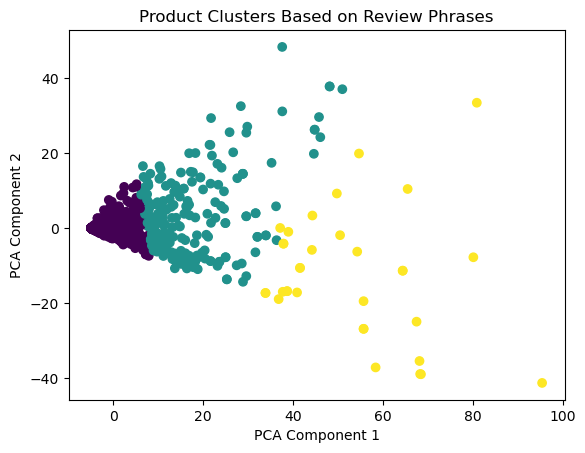

In [162]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_product_phrases)

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=product_clusters, cmap='viridis')
plt.title('Product Clusters Based on Review Phrases')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

<b> Clustering products using TFID </b>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)
X = vectorizer.fit_transform(cleaned_combined_reviews['cleaned_review_text'])

# Group the review vectors by product
product_reviews = cleaned_combined_reviews.groupby('product_name')['cleaned_review_text'].apply(lambda x: ' '.join(x))

# Vectorize the combined product reviews
product_X = vectorizer.transform(product_reviews)

#Kmeans
kmeans = KMeans(n_clusters=5, random_state=42)  # You can adjust the number of clusters
kmeans.fit(product_X)

# Add cluster labels to the product_reviews dataframe
product_reviews_df = pd.DataFrame(product_reviews)
product_reviews_df['cluster'] = kmeans.labels_


print("Clustered Products:")
print(product_reviews_df.head())


for cluster in range(5):
    print(f"\nProducts in Cluster {cluster}:")
    print(product_reviews_df[product_reviews_df['cluster'] == cluster].index.tolist())


Cleared output do to size but displayed clusters

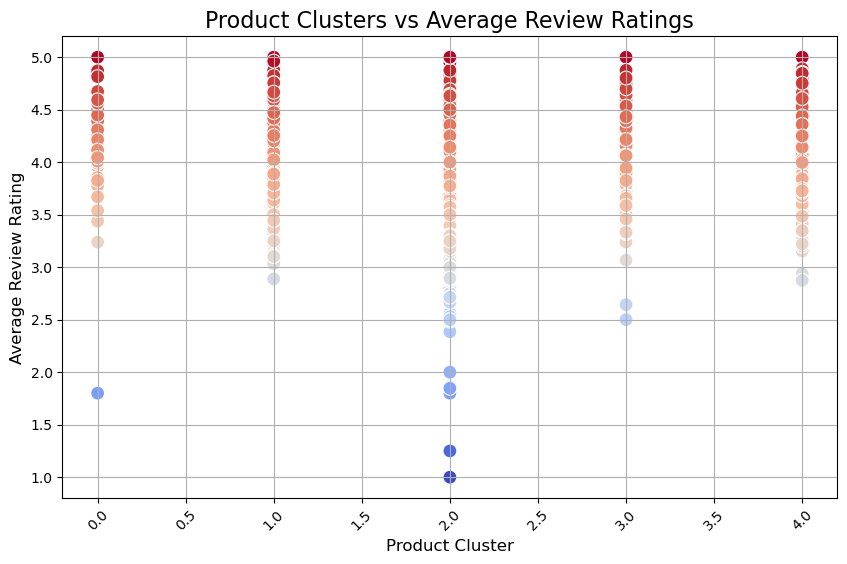

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

#Calculate average rating or sentiment per product
product_ratings = cleaned_combined_reviews.groupby('product_name')['rating'].mean()  # Or 'sentiment' if using sentiment analysis

# Combine the product reviews DataFrame with the ratings/sentiment DataFrame
product_reviews_df['average_rating'] = product_ratings

# Plot the clusters and their corresponding average ratings/sentiments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_reviews_df, x='cluster', y='average_rating', hue='average_rating', palette='coolwarm', s=100, legend=None)

# Adding titles and labels
plt.title('Product Clusters vs Average Review Ratings', fontsize=16)
plt.xlabel('Product Cluster', fontsize=12)
plt.ylabel('Average Review Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# combine reviews by user
user_reviews = cleaned_combined_reviews.groupby('author_id')['cleaned_review_text'].apply(lambda x: ' '.join(x))

# Vectorize user reviews using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=1000)
user_X = vectorizer.fit_transform(user_reviews)

# Apply KMeans clustering to group similar users
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
user_clusters = kmeans.fit_predict(user_X)


user_reviews_df = pd.DataFrame(user_reviews)
user_reviews_df['cluster'] = user_clusters

#
print("Clustered Users:")
print(user_reviews_df.head())

# Check which products users in each cluster have reviewed
for cluster in range(5):
    print(f"\nUsers in Cluster {cluster}:")
    users_in_cluster = user_reviews_df[user_reviews_df['cluster'] == cluster].index.tolist()
    reviewed_products = cleaned_combined_reviews[cleaned_combined_reviews['author_id'].isin(users_in_cluster)]['product_name'].unique()
    print(f"Products reviewed by users in cluster {cluster}: {reviewed_products}")


Cleared the output due to the size but provided each cluster (0 to 4), you will see which products were reviewed by users in that cluster. 

<b> Visualize the clustering of users by review </b>

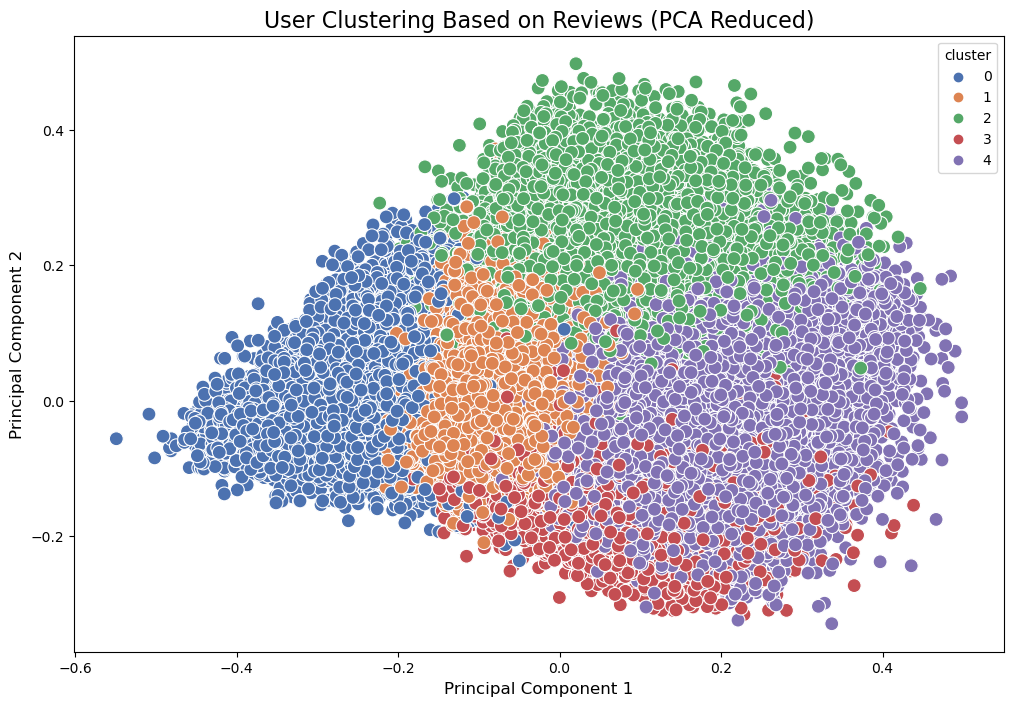

In [166]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#Apply PCA for 2D visualization of user clusters
pca = PCA(n_components=2)
user_X_pca = pca.fit_transform(user_X.toarray())  # Convert sparse matrix to dense array

# Create a DataFrame for the PCA-transformed data
pca_df = pd.DataFrame(user_X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = user_clusters
pca_df['author_id'] = user_reviews.index

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='deep', s=100, legend="full")

# Add titles and labels
plt.title('User Clustering Based on Reviews (PCA Reduced)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.show()


<b>Use Naive Bayes to predict which cluster a user belongs to</b>

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score


X = user_X.toarray()  # TF-IDF vectorized user reviews (features)
y = user_clusters      # Cluster labels (target)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Train a Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8036302679785249
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      9984
           1       0.77      0.90      0.83     77437
           2       0.96      0.78      0.86     16110
           3       0.95      0.49      0.65     13622
           4       0.78      0.76      0.77     56443

    accuracy                           0.80    173596
   macro avg       0.89      0.73      0.79    173596
weighted avg       0.82      0.80      0.80    173596



## Lorena Dorado

# Collaborative Filtering Recommendation System
**Lorena Dorado**

* Building a Product Recommendation Engine
* Import Libraries and Setup

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithZScore, NormalPredictor
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import accuracy
from IPython.display import display, HTML
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import random

## Data Loading and Initial Exploration
This section loads the data and performs initial checks on the dataset as well as preenting data type related issues to improve performance. All of the reviews are combined to have as much data as we can.

In [2]:
# Define the data loading function
def load_data():
    project_root = os.getcwd()
    datasets = os.path.join(project_root, "datasets/")
    
    # Define the dtype for both author_id and product_id to avoid mixed types
    dtype_dict = {
        'author_id': str,
        'product_id': str
    }
    
    # Load product info and reviews
    product_info = pd.read_csv(os.path.join(datasets, "product_info.csv"), dtype=dtype_dict)
    reviews_files = [
        "reviews_0-250.csv", "reviews_250-500.csv", 
        "reviews_500-750.csv", "reviews_750-1250.csv", 
        "reviews_1250-end.csv"
    ]
    
    all_reviews = []
    for file in reviews_files:
        reviews = pd.read_csv(os.path.join(datasets, file), dtype=dtype_dict)
        all_reviews.append(reviews)
    
    # Concatenate all reviews and remove duplicates
    all_reviews = pd.concat(all_reviews, ignore_index=True).drop_duplicates()
    
    return product_info, all_reviews


# Load the data
product_info, all_reviews = load_data()

# Display basic information about the datasets
print("Product Info Shape:", product_info.shape)
print("All Reviews Shape:", all_reviews.shape)

# Display sample of product info
display(product_info.head())
display(all_reviews.head())

Product Info Shape: (8494, 27)
All Reviews Shape: (1094411, 19)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


## Data Preprocessing
This section handles missing values and prepares the data for model training.

The following are the variables that we will be working with for the reccommendation model and improve its predictive power. These columns can help the recommendation system better understand user preferences and product characteristics. These variables have no missing values. `product_id` can be linked between the two datasets.

#### Product Info
    product_id
    product_name
    brand_name


#### Reviews
    author_id
    product_id
    rating

In [3]:
# Review the two datasets
datasets = os.path.join("datasets/")
product_info_indexed = pd.read_csv(datasets + "product_info.csv", index_col="product_id")
product_cols = product_info[['product_id', 'product_name', 'brand_name']].sample(n=100, random_state=1).head()
reviews_rows = all_reviews[['author_id', 'product_id', 'rating']].sample(n=100, random_state=1).head()

display(HTML(
    f"""
    <div style="display: flex; justify-content: center;">
        <div style="margin-right: 30px;">
            <h3>Product Info</h3>
            {product_cols.to_html(index=False)}
            <br />
            <h3>Reviews</h3>
            {reviews_rows.to_html(index=False)}
        </div>
    </div>
    """
))

product_id,product_name,brand_name
P375375,Angled Liner Brush,Hourglass
P434429,Resistance Strengthening Conditioner for Damaged Hair,Kérastase
P502169,Barrier+ Besties Hydrating and Nourishing Kit,Skinfix
P483092,Glow Peel Pads with AHA + PHA,SEPHORA COLLECTION
P471261,Daisy Eau So Intense Eau de Parfum,Marc Jacobs Fragrances
author_id,product_id,rating
37301111097,P500121,2
5138189587,P454838,4
811891666,P481335,5
22214579608,P467762,4


#### Create a sample Matrix (summarizes all reviews across all products)

The following table shows which products have been rated by which users; use pandas pivot table (takes a list of data and summarizes it with one row (for ea unique user) and one column (for ea unique product) in the dataset.
- 1 row per user
- 1 column per product

In [4]:
# Sample 100 rows from the all_reviews DataFrame
sampled_all_reviews = all_reviews.sample(n=100, random_state=1)

# Create your pivot table from the sampled data
sample_df = pd.pivot_table(sampled_all_reviews, index='author_id', columns='product_id', values='rating', aggfunc='max', fill_value="")

# Create a CSV file of the sampled data
sample_df.to_csv("review_matrix_sampled.csv", na_rep="")
sample_df

product_id,P122762,P122774,P12336,P201440,P218700,P270594,P278317,P297524,P375534,P381030,...,P484080,P500121,P500288,P500894,P501421,P503250,P504042,P504045,P504320,P504986
author_id,,,,,,,,,,,,,,,,,,,,,
1004216492,,,,4,,,,,,,...,,,,,,,,,,
10624026829,,,,,,,,,,,...,,,,,,,,,,
1078393772,,,,,,,,,,,...,,,,,,,,,,
1121421989,,,,,,,,,,,...,,,,,,,,,5,
11366017341,,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811891666,,,,,,,,,,,...,,,,,,,,,,
8477019138,,,,,,,,,,,...,,,,,,,,,,
8639995150,,,,,,,,,,,...,,,,,,,,,,


This matrix shows that a majority of potential interactions or values are absent. Algorithms of the Surprise library like k-nearest neighbors (KNN) and matrix factorization techniques are designed to handle these sparse datasets effectively.

The user IDs are string data types so to improve efficiency, we are transforming those to integer indices

In [5]:
# Define preprocessing methods
def preprocess_data(product_info, all_reviews):
    # Merge product info with reviews
    merged_df = all_reviews.merge(
        product_info[['product_id', 'product_name', 'brand_name']], 
        on='product_id', 
        how='left'
    )
    
    # Check for missing values
    print("Missing values:")
    print(merged_df.isnull().sum())
    
    # Create mapping dictionaries for users and items
    user_mapper = {id_: idx for idx, id_ in enumerate(merged_df['author_id'].unique())}
    item_mapper = {id_: idx for idx, id_ in enumerate(merged_df['product_id'].unique())}
    
    # Create reverse mappers
    reverse_user_mapper = {v: k for k, v in user_mapper.items()}
    reverse_item_mapper = {v: k for k, v in item_mapper.items()}
    
    # Transform IDs to numerical indices
    merged_df['user_idx'] = merged_df['author_id'].map(user_mapper)
    merged_df['item_idx'] = merged_df['product_id'].map(item_mapper)
    
    return merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper

# Preprocess the data
merged_df, user_mapper, item_mapper, reverse_user_mapper, reverse_item_mapper = preprocess_data(product_info, all_reviews)

Missing values:
Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name_x                   0
brand_name_x                     0
price_usd                        0
product_name_y                   0
brand_name_y                     0
dtype: int64


When using the Surprise library, having complete records for the key columns `product_id`, `author_id`, and `rating` is sufficient. We don’t need to handle missing values in irrelevant columns, as Surprise only requires the key columns for building and training recommendation models.

## Exploratory Data Analysis
This section prepare visualizations to gain preliminary insights into the data.

* Examine the distribution of ratings
* Identify which skincare brand has the highest number of ratings
* Analyze the average number of reviews each user typically leaves

In [6]:
# Count unique product IDs and author IDs
unique_product_count = all_reviews['product_id'].nunique()
unique_author_count = all_reviews['author_id'].nunique()

# Print results
print(f"Unique product IDs: {unique_product_count}")
print(f"Unique author IDs: {unique_author_count}")

Unique product IDs: 2351
Unique author IDs: 503216


There were at least 503,216 customers who contributed to over 1 million reviews across 2,351  different skincare products.

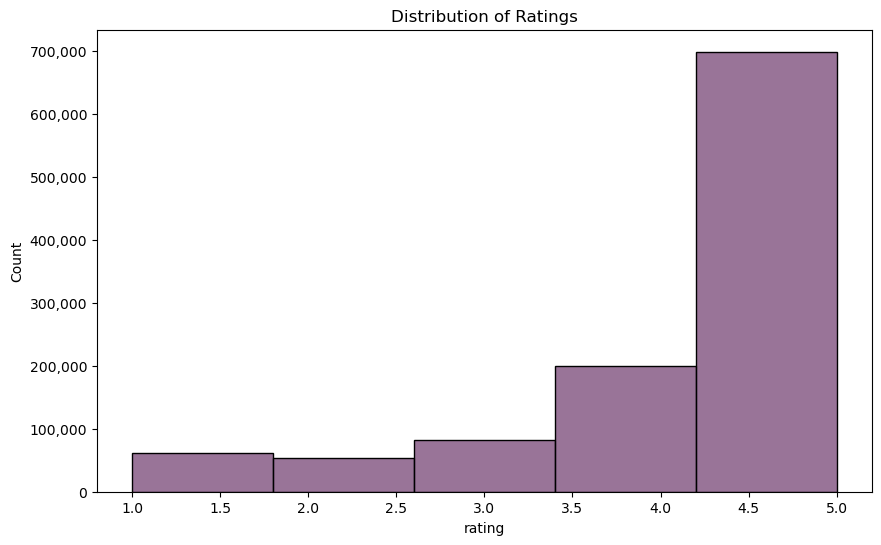


Rating Statistics:
count    1.094411e+06
mean     4.299158e+00
std      1.149444e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [7]:
# 1. Rating Distribution
def comma_formatter(x, _):
    return f'{int(x):,}'

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['rating'], bins=5, color='#774576')
plt.title('Distribution of Ratings')
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.show()

print("\nRating Statistics:")
print(merged_df['rating'].describe())

The majority of users rate products high (4s or 5s).

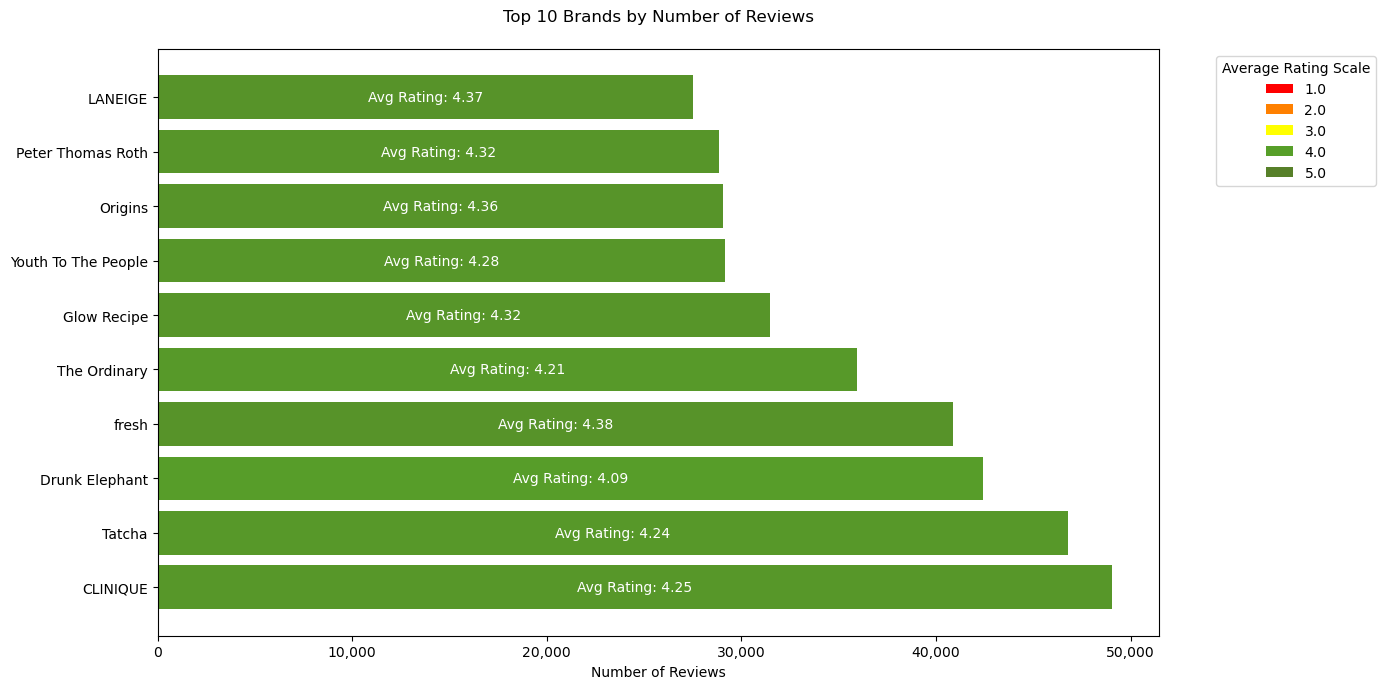

In [8]:
# Calculate average ratings and get top 10 brands by review count
top_brands_df = (merged_df.groupby('brand_name_x')['rating']
                 .agg(['mean', 'count'])
                 .nlargest(10, 'count')
                 .reset_index()
                 .rename(columns={'mean': 'avg_rating', 'count': 'review_count'}))

# Define color mapping based on average rating
def rating_to_color(rating):
    normalized = (rating - 1) / 4  # Map rating 1-5 to 0-1 for color range
    if normalized <= 0.5:
        # Red to Yellow
        return (1.0, 2 * normalized, 0.0)  # RGB values in [0, 1]
    else:
        # Yellow to Dark Green
        return (0.34, 0.5 + 0.5 * (1 - normalized), 0.16)  # dark green RGB values

# Generate colors based on ratings
colors = [rating_to_color(rating) for rating in top_brands_df['avg_rating']]

# Plot bar chart
plt.figure(figsize=(14, 7))
bars = plt.barh(top_brands_df['brand_name_x'], top_brands_df['review_count'], color=colors)

# Annotate bars with average rating inside
for bar, avg_rating in zip(bars, top_brands_df['avg_rating']):
    plt.text(bar.get_width() / 2,  # Center the text horizontally in the bar
             bar.get_y() + bar.get_height()/2,  # Center the text vertically
             f'Avg Rating: {avg_rating:.2f}', 
             ha='center',  # Horizontal alignment
             va='center',  # Vertical alignment
             color='white',  # Text color
             fontsize=10)   # Font size

# Title and labels
plt.title('Top 10 Brands by Number of Reviews', pad=20)
plt.xlabel('Number of Reviews')

# Color legend for rating scale
legend_elements = [patches.Patch(facecolor=rating_to_color(r), label=f'{r}.0') for r in range(1, 6)]
plt.legend(handles=legend_elements, title='Average Rating Scale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.tight_layout()
plt.show()

CLINIQUE and Tatcha are reviewed frequently.

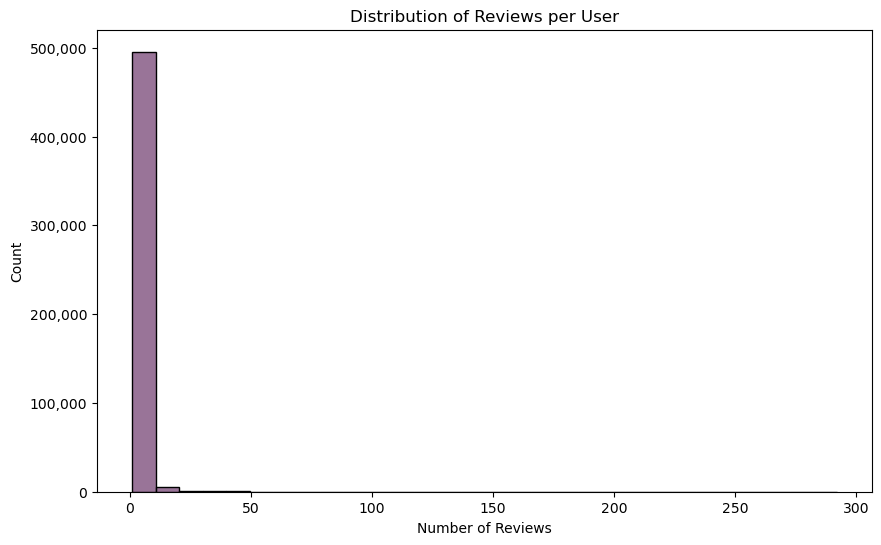


User Activity Statistics:
count    503216.000000
mean          2.174833
std           3.414628
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         292.000000
dtype: float64


In [9]:
# 3. User Activity Analysis
user_activity = merged_df.groupby('author_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(user_activity, bins=30, color='#774576')
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_formatter))
plt.show()
    
print("\nUser Activity Statistics:")
print(user_activity.describe())

Most customers who leave reviews on the Sephora website typically submit just one review. However, some users have posted as many as 292 reviews.

Use the Reader class in the Surprise library for parsing and reading the rating data. I have indicated that the ratings can range from 1 to 5. This helps in training algorithms and validating predictions.

Data normalization can improve recommendation model performance by adjusting for users who consistently rate items lower or higher than others, helping to reduce bias for fairer, more accurate recommendations. In the Surprise library, only KNNWithZScore includes built-in normalization to account for user rating patterns. Since the ratings are bound in the 1 to 5 range, using non-normalized data across models (instead of applying additional normalization) allows for direct comparison with KNNWithZScore, ensuring consistency in performance evaluation.

A subset is created from the `merged_df` dataset, containing user-item interactions and their ratings. This subset is then loaded into a format that the Surprise library can understand for training recommendation models. The `data` variable is defined as a Surprise Dataset object that can be used with various algorithms for collaborative filtering, matrix factorization, or other recommendation techniques.

## Model Training and Evaluation
* This section prepares the data for the Surprise library and trains multiple models to create a similarity matrix.
* We will be trying different algorithms (SVD, KNNWithZScore, KNNBasic, and NormalPredictor) to compare performance
* These models compute similarities between items or users, similar to collaborative filtering.
* Each model instance will be implemented with varying hyperparameters.

**SVD (Singular Value Decomposition):** a matrix factorization technique used in collaborative filtering. It decomposes the user-item interaction matrix into three matrices: user features, item features, and singular values. It predicts user preferences by approximating the original matrix with these decomposed matrices, capturing latent factors that explain the observed ratings.

**KNNWithZScore:** a k-nearest neighbors (k-NN) algorithm that incorporates z-score normalization. In other words, it automatically normalizes the data by converting the ratings into z-scores so we do not have to in preprocessing. It adjusts ratings by subtracting the mean and dividing by the standard deviation of each user’s ratings. It computes similarities between users or items based on these normalized ratings, making predictions by aggregating the ratings of the nearest neighbors.

**KNNBasic:** a straightforward k-NN algorithm for collaborative filtering. It computes the similarity between users or items and uses these similarities to predict ratings. The prediction is made by taking a weighted average of the ratings from the most similar users or items.

**NormalPredictor:** a baseline algorithm that predicts ratings randomly based on the distribution of the training set. It assumes the ratings follow a normal distribution. It generates predictions by sampling from this normal distribution, providing a simple benchmark for comparing other algorithms

In [10]:
def train_and_evaluate_base_models(merged_df):
    # Prepare data for Surprise
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)
    
    # Split into training and test set
    base_trainset, base_testset = surprise_train_test_split(data, test_size=0.25, random_state=42)
    
    # Initialize base_models
    base_models = {
        'SVD': SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02),
        'KNNWithZScore': KNNWithZScore(sim_options={'name': 'pearson_baseline', 'user_based': False}, k=40),
        'KNNBasic': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, k=30),
        'NormalPredictor': NormalPredictor()
    }
    
    # Train and evaluate each model
    base_results = {}
    for name, model in base_models.items():
        print(f"\nTraining {name}...")
        model.fit(base_trainset)
        predictions = model.test(base_testset)
        base_results[name] = predictions
    
    return base_results, base_trainset, base_testset, base_models

# Train and evaluate base_models
base_results, base_trainset, base_testset, base_models = train_and_evaluate_base_models(merged_df)


Training SVD...

Training KNNWithZScore...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Training KNNBasic...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Training NormalPredictor...


Comparing RMSE and MAE helps evaluate model performance more comprehensively because each metric highlights different aspects of error. MAE shows the average error without emphasizing any specific value, while RMSE gives extra weight to larger errors, making it more sensitive to outliers. Looking at both provides insight into general accuracy (from MAE) and the model’s response to large deviations (from RMSE), gaining a clear understanding of where the model performs well and where it might struggle.

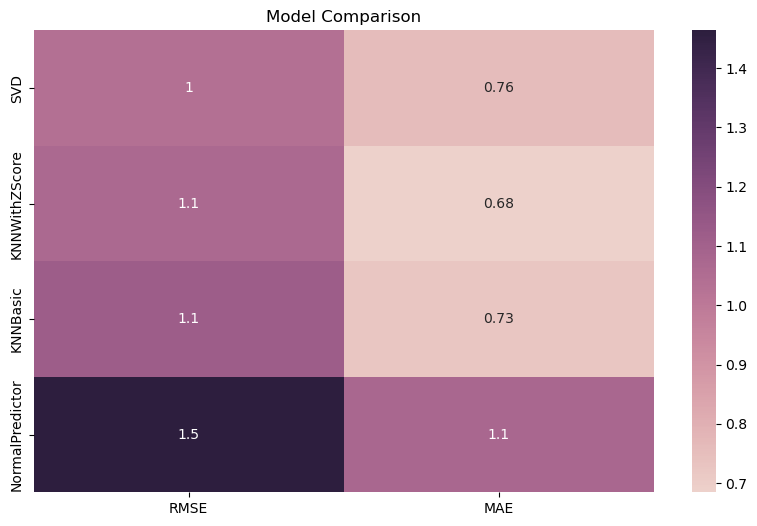

In [11]:
def compare_base_models(base_results):
    base_model_metrics = {}
    for name, predictions in base_results.items():
        rmse = np.sqrt(np.mean([(p.r_ui - p.est) ** 2 for p in predictions]))
        mae = np.mean([abs(p.r_ui - p.est) for p in predictions])
        base_model_metrics[name] = {'RMSE': rmse, 'MAE': mae}
    
    base_metrics = pd.DataFrame(base_model_metrics).T
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(base_metrics, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title('Model Comparison')
    plt.show()
    
    return base_metrics

# Compare models
base_metrics = compare_base_models(base_results)

After training the models, it predicts the rating a user would give to a specific item on a scale from 1 to 5, based on their past behavior and the behavior of similar users or items.

KNNWithZScore has the lowest mean absolute error of 0.68, outperforming the rest of the models. We will analyze KNNWithZScore which used a non normalized training set because the Surprise library has an internal normalization method for this model.

In [12]:
# Display the first 5 predictions generated
first_five_knn = base_results['KNNWithZScore'][:5]

first_preds_knn = [{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in first_five_knn]

# Create a DataFrame
five_preds_knn = pd.DataFrame(first_preds_knn)
five_preds_knn

,user_id,item_id,actual_rating,estimated_rating
0,62051,9,5.0,5.000000
1,60554,144,5.0,3.805675
2,423488,547,5.0,4.298982
3,186131,61,1.0,2.311481
4,235961,783,5.0,4.727081


**Best Prediction:** user_id 62051, with an exact prediction

**Worst Prediction:** user_id 186131, with a difference of 1.311481, indicating the model overestimated the rating for this user.

For user_id 186131, with an actual rating of 1.0, the estimated rating is 2.31. This suggests the model may struggle to predict very low ratings accurately, potentially overestimating item relevance. This can happen when the model lacks sufficient data on negative feedback or lower ratings.

## Model Comparison and Hyperparameter Tuning
This section compares different models and performs hyperparameter tuning for the best model. We will train models using cross-validation for hyperparameter tuning.

**SVD Hyperparameters:**

- **n_factors:** The number of latent factors (higher values can capture more complex patterns but may lead to overfitting)
- **n_epochs:** Number of iterations over the training data (more epochs can lead to better convergence but increases training time)
- **lr_all:** Learning rate for all parameters (higher values can lead to faster convergence but may cause instability)
- **reg_all:** Regularization term for all parameters (higher values prevent overfitting but may lead to underfitting)


**KNNWithZScore & KNNBasic Hyperparameters:**

- **sim_options:** Similarity measure (e.g., 'pearson_baseline', 'cosine') and whether to compute similarities between users (True) or items (False)
- **k:** Number of neighbors ( The higher k smooths out predictions but may introduce irrelevant neighbors)

**NormalPredictor Hyperparameters:** None

Define parameter grids for KNNWithZScore and KNNBasic

In [13]:
param_grid_knn_zscore = {
    'k': [20, 30, 40, 50],
    'sim_options': {
        'name': ['pearson_baseline', 'cosine'],
        'user_based': [False]
    }
}

param_grid_knn_basic = {
    'k': [20, 30, 40, 50],
    'sim_options': {
        'name': ['cosine', 'msd'],
        'user_based': [False]
    }
}

GridSearchCV tests different hyperparameter combinations (defined in the param_grids) and evaluate them on rmse and mae error metrics across five folds. The function fits the grid search on the merged data, identifies the best hyperparameters for minimizing RMSE and the cross-validation results.

In [14]:
# Prepare to train models with cross-validation for hyperparameter tuning
def tune_model_with_cv(algo_class, data, param_grid, cv=5):
    gs = GridSearchCV(
        algo_class,
        param_grid,
        measures=['rmse', 'mae'],
        cv=cv,
        n_jobs=-1,
        joblib_verbose=1
    )
    
    gs.fit(data)
    
    best_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print(f"Best parameters for {algo_class.__name__}: {best_params}")
    print(f"Best RMSE for {algo_class.__name__}: {best_score}")
    
    return best_params, pd.DataFrame.from_dict(gs.cv_results)

Perform hyperparameter tuning for the three algorithm class we are working with using cross-validation. 

Data splitting is performed using the Surprise library’s Dataset class. Therefore cross-validation for hyperparameter tuning implicitly splits the data into training and validation sets multiple times.

In [15]:
def train_and_evaluate_models(merged_df):
    # merged_df = merged_df.sample(n=100, random_state=42)
    # Prepare data for Surprise
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(merged_df[['user_idx', 'item_idx', 'rating']], reader)
    
    # Define parameter grids
    param_grid_svd = {
        'n_factors': [50, 100, 150],
        'n_epochs': [10, 20, 30],
        'lr_all': [0.002, 0.005, 0.007],
        'reg_all': [0.02, 0.04, 0.06]
    }
    
    param_grid_knn_zscore = {
        'k': [20, 30, 40, 50],
        'sim_options': {
            'name': ['pearson_baseline', 'cosine'],
            'user_based': [False]
        }
    }

    param_grid_knn_basic = {
        'k': [20, 30, 40, 50],
        'sim_options': {
            'name': ['cosine', 'msd'],
            'user_based': [False]
        }
    }
    
    # Perform hyperparameter tuning
    best_params_svd, cv_results_svd = tune_model_with_cv(SVD, data, param_grid_svd)
    best_params_knn_zscore, cv_results_knn_zscore = tune_model_with_cv(KNNWithZScore, data, param_grid_knn_zscore)
    best_params_knn_basic, cv_results_knn_basic = tune_model_with_cv(KNNBasic, data, param_grid_knn_basic)
    
    # Save best_params and cv_results to CSV files
    pd.DataFrame([best_params_svd]).to_csv('best_params_svd.csv', index=False)
    pd.DataFrame([best_params_knn_zscore]).to_csv('best_params_knn_zscore.csv', index=False)
    pd.DataFrame([best_params_knn_basic]).to_csv('best_params_knn_basic.csv', index=False)
    
    pd.DataFrame(cv_results_svd).to_csv('cv_results_svd.csv', index=False)
    pd.DataFrame(cv_results_knn_zscore).to_csv('cv_results_knn_zscore.csv', index=False)
    pd.DataFrame(cv_results_knn_basic).to_csv('cv_results_knn_basic.csv', index=False)
    
    # Create and evaluate final models
    best_model_svd = SVD(**best_params_svd)
    best_model_knn_zscore = KNNWithZScore(**best_params_knn_zscore)
    best_model_knn_basic = KNNBasic(**best_params_knn_basic)
    
    trainset = data.build_full_trainset()
    best_model_svd.fit(trainset)
    best_model_knn_zscore.fit(trainset)
    best_model_knn_basic.fit(trainset)
    
    # Initialize other models
    models = {
        'SVD': best_model_svd,
        'KNNWithZScore': best_model_knn_zscore,
        'KNNBasic': best_model_knn_basic,
        #'NormalPredictor': NormalPredictor()
    }
    
    # Train and evaluate each model
    results = {}
    testset = trainset.build_testset()
    for name, model in models.items():
        if name != 'NormalPredictor':
            model.fit(trainset)
        predictions = model.test(testset)
        results[name] = predictions
    
    return {
        'results': results,
        'models': models,
        'best_params': {
            'SVD': best_params_svd,
            'KNNWithZScore': best_params_knn_zscore,
            'KNNBasic': best_params_knn_basic
        },
        'cv_results': {
            'SVD': cv_results_svd,
            'KNNWithZScore': cv_results_knn_zscore,
            'KNNBasic': cv_results_knn_basic
        }
    }

# Train and evaluate models
model_data = train_and_evaluate_models(merged_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 22.2min finished


Best parameters for SVD: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.02}
Best RMSE for SVD: 1.0079745607047523


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


Best parameters for KNNWithZScore: {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}
Best RMSE for KNNWithZScore: 1.0608779094631302


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Best parameters for KNNBasic: {'k': 30, 'sim_options': {'name': 'msd', 'user_based': False}}
Best RMSE for KNNBasic: 1.1040396073157432
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


**Best parameters for SVD:** {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.007, 'reg_all': 0.02}
**Best RMSE for SVD:** 1.0086199510226432

**Best parameters for KNNWithZScore:** {'k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}
**Best RMSE for KNNWithZScore:** 1.061254378818212

**est parameters for KNNBasic:** {'k': 50, 'sim_options': {'name': 'msd', 'user_based': False}}
vBest RMSE for KNNBasic:** 1.1041490018792703

Visualize and compare the performance of our models with the best parameters.

The lift chart compares the models' performance against a perfect and random  model based on the cumulative distribution of predicted ratings. The predictions involve rating of items by users. Higher estimates from the model_data results are plotted first. The closer the model's line is to the perfect model line, the better the model's performance.

The perfect model shows the ideal scenario where all the highest-rated items are predicted first.

The random model is a straight line from 0 to the total cumulative rating.

Then the top 20% index will be annotated to indicate where the most significant differences might be observed.

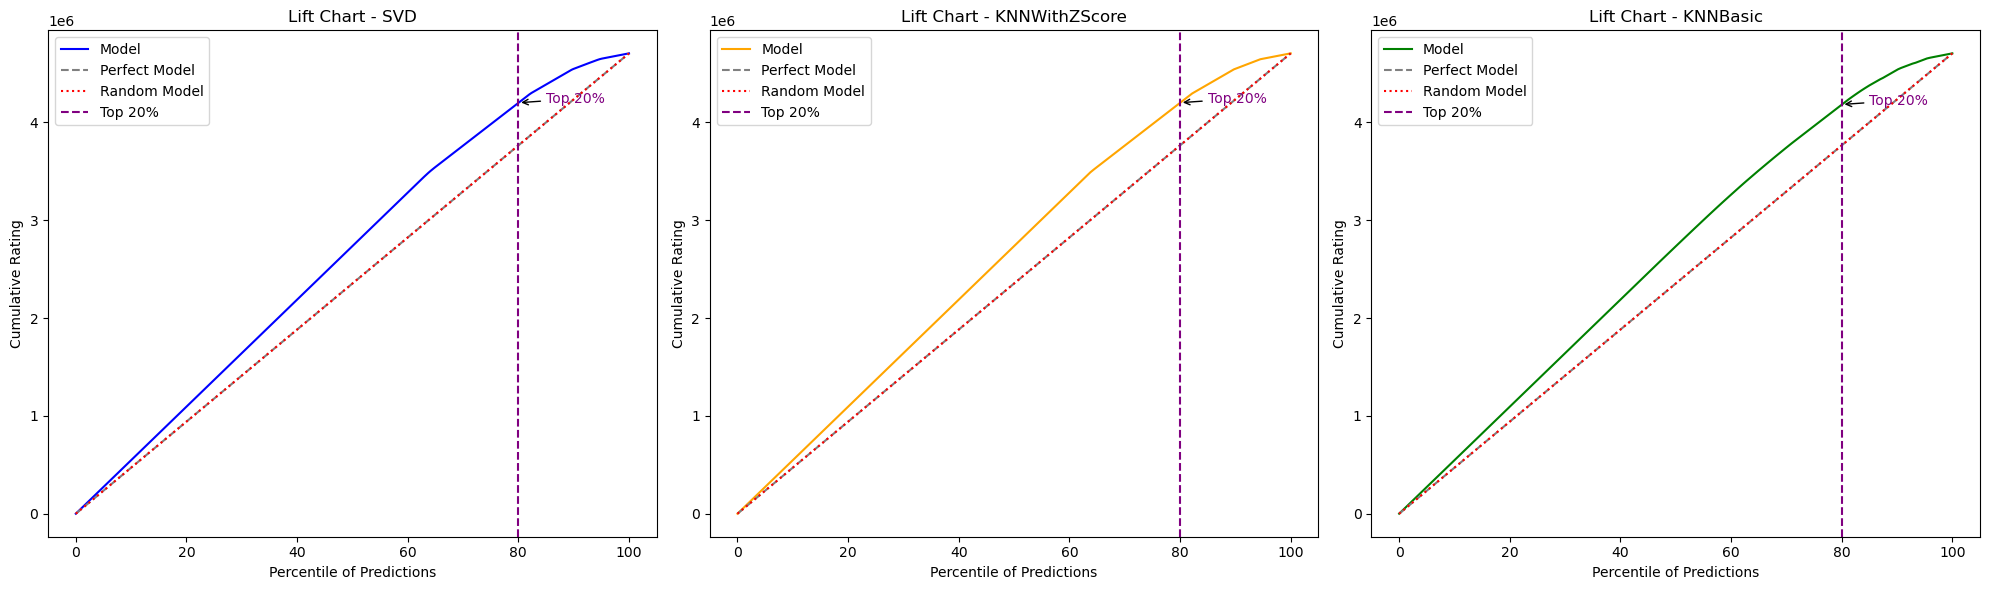

In [22]:
def liftChart(predictions, title, color, ax, top_percent=20):
    # Sort predictions by estimated rating in descending order
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    
    # Calculate cumulative actual ratings and perfect model
    actual_ratings = np.cumsum([pred.r_ui for pred in sorted_predictions])
    total_ratings = sum(pred.r_ui for pred in predictions)
    perfect_model = np.linspace(0, total_ratings, len(predictions))
    random_model = np.linspace(0, total_ratings, len(predictions))
    
    # Calculate percentiles
    percentiles = np.linspace(0, 100, len(predictions))
    
    # Plot the lift chart
    ax.plot(percentiles, actual_ratings, label='Model', color=color)
    ax.plot(percentiles, perfect_model, label='Perfect Model', color='gray', linestyle='--')
    ax.plot(percentiles, random_model, label='Random Model', color='red', linestyle=':')
    
    # Annotate the top percentile region (e.g., top 20%)
    top_index = int(len(predictions) * (1 - top_percent / 100))
    ax.axvline(percentiles[top_index], color='purple', linestyle='--', label=f'Top {top_percent}%')
    ax.annotate(
        f'Top {top_percent}%',
        xy=(percentiles[top_index], actual_ratings[top_index]),
        xytext=(percentiles[top_index] + 5, actual_ratings[top_index]),
        arrowprops=dict(facecolor='purple', arrowstyle='->'),
        color='purple'
    )
    
    ax.set_xlabel('Percentile of Predictions')
    ax.set_ylabel('Cumulative Rating')
    ax.set_title(title)
    ax.legend()
    
    return ax

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# Define colors for each model
colors = ['blue', 'orange', 'green']

# Generate lift charts for each model with top 20% annotation
for i, (model_name, predictions) in enumerate(model_data['results'].items()):
    liftChart(predictions, f'Lift Chart - {model_name}', colors[i], axes[i], top_percent=20)

plt.tight_layout()
plt.show()

**SVD:** shows a slight improvement over the random model (red dotted line), especially in the middle percentiles. This indicates that the SVD model is providing some predictive power, but the improvement is modest.

**KNNWithZScore:** shows a more noticeable improvement over the random model, with a steeper curve in the early percentiles. It suggests that this model is better at identifying the higher-rated items compared to the SVD model.

**KNNBasic** similar performance to the KNNWithZScore model, showing improvement over the random model, especially in the early and middle percentiles.

Top 20% represents the 80th percentile of predictions. In these charts, we can see that the three models capture more cumulative rating in their top 20% of predictions compared to the random model, meaning that they are effective at identifying and recommending higher-rated items.

The difference between the models' performance is small compared to the total cumulative rating. This indicates that even though the collaborative filtering models are show some improvement over random guessing, the improvement is not significant.

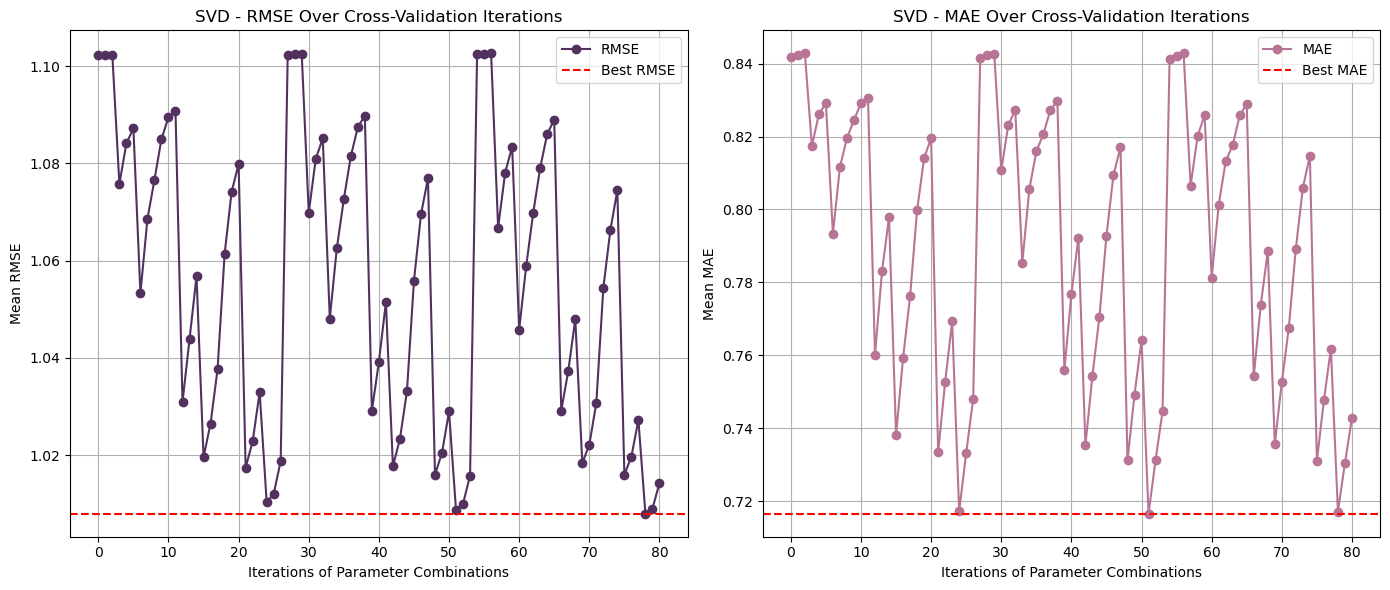

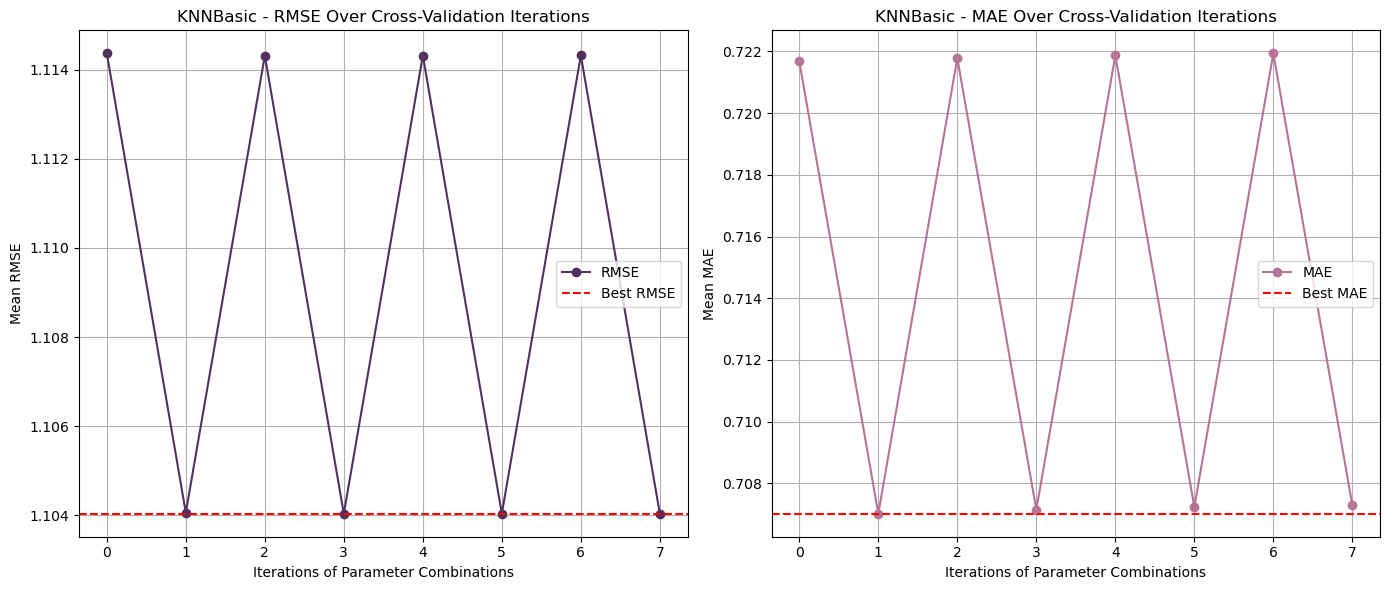

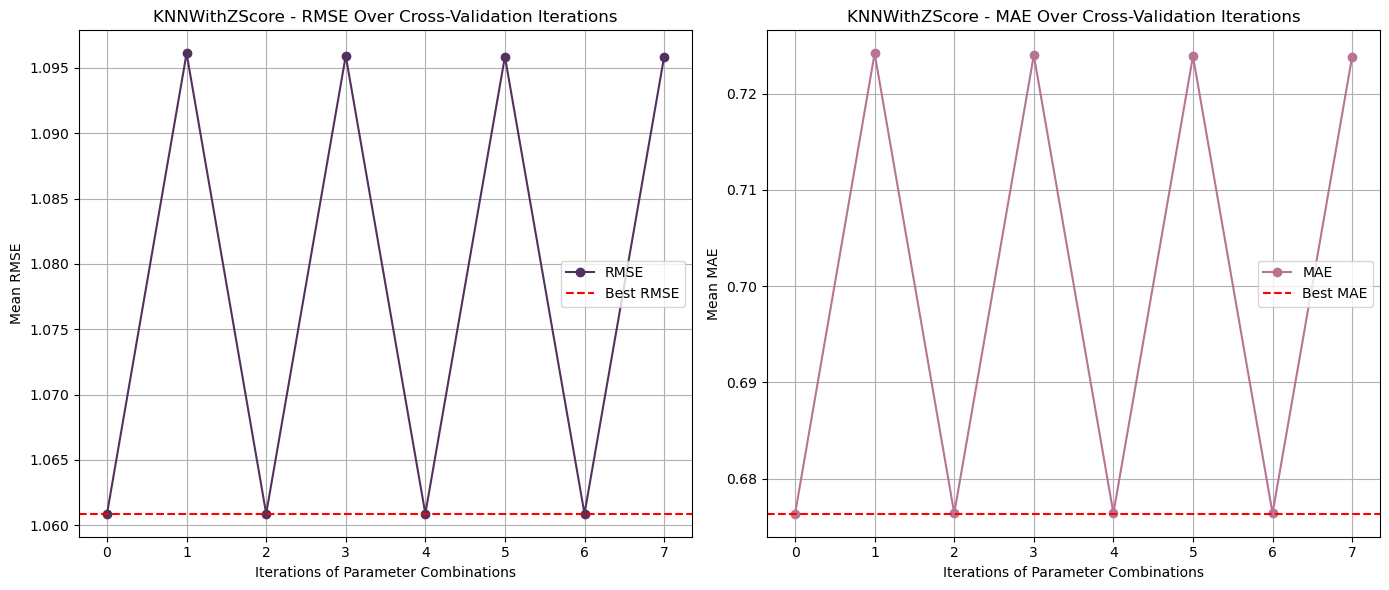

In [17]:
def plot_cv_results(cv_results, model_name, rmse_color='#52315f', mae_color='#b77495', best_line_color='r'):
    if 'mean_test_rmse' not in cv_results or 'mean_test_mae' not in cv_results:
        raise ValueError("cv_results must contain 'mean_test_rmse' and 'mean_test_mae' columns")

    plt.figure(figsize=(14, 6))

    # Plot RMSE over iterations
    plt.subplot(1, 2, 1)
    plt.plot(cv_results['mean_test_rmse'], marker='o', color=rmse_color, label='RMSE')
    plt.xlabel("Iterations of Parameter Combinations")
    plt.ylabel("Mean RMSE")
    plt.title(f"{model_name} - RMSE Over Cross-Validation Iterations")
    plt.axhline(y=min(cv_results['mean_test_rmse']), color=best_line_color, linestyle='--', label='Best RMSE')
    plt.legend()
    plt.grid(True)

    # Plot MAE over iterations
    plt.subplot(1, 2, 2)
    plt.plot(cv_results['mean_test_mae'], marker='o', color=mae_color, label='MAE')
    plt.xlabel("Iterations of Parameter Combinations")
    plt.ylabel("Mean MAE")
    plt.title(f"{model_name} - MAE Over Cross-Validation Iterations")
    plt.axhline(y=min(cv_results['mean_test_mae']), color=best_line_color, linestyle='--', label='Best MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage with cv_results from train_and_evaluate_models
plot_cv_results(model_data['cv_results']['SVD'], 'SVD')
plot_cv_results(model_data['cv_results']['KNNBasic'], 'KNNBasic')
plot_cv_results(model_data['cv_results']['KNNWithZScore'], 'KNNWithZScore')

The 5-fold cross-validation ensures that the chosen parameters for the models effectively generalize across five equally sized subsets of the data. This approach helps reduce the risk of overfitting to any specific training or validation set by allowing the model to be evaluated on different portions of the data.

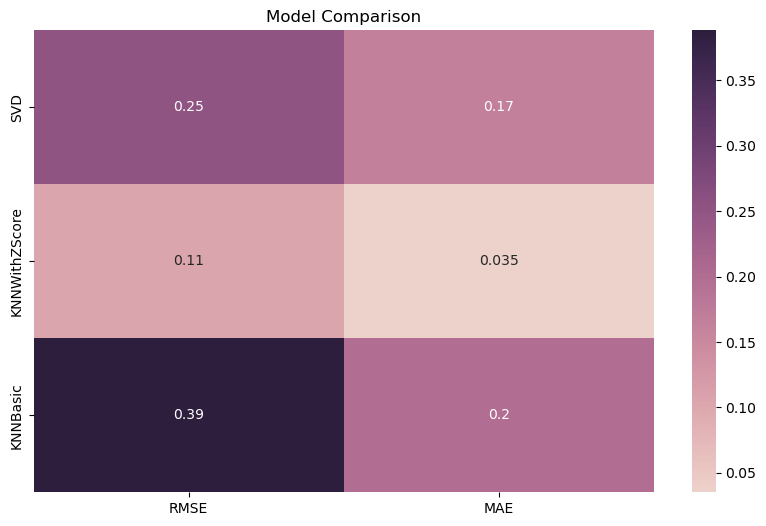

In [18]:
# Compare models
def compare_models(model_data):
    results = model_data['results']
    model_metrics = {}
    for name, predictions in results.items():
        rmse = np.sqrt(np.mean([(p.r_ui - p.est)**2 for p in predictions]))
        mae = np.mean([abs(p.r_ui - p.est) for p in predictions])
        model_metrics[name] = {'RMSE': rmse, 'MAE': mae}
    
    metrics_df = pd.DataFrame(model_metrics).T
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title('Model Comparison')
    plt.show()
    
    return metrics_df

# Compare models
metrics_df = compare_models(model_data)

With the optimized parameters, the KNNWithZScore model shows strong predictive accuracy, with an average error of only 0.035 (MAE). RMSE of 0.11 indicates that even when squared errors are factored in, the model maintains a low overall error, meaning there are very few large errors.

This model outperforms the rest and is selected as the best due to its minimal deviation from actual ratings.

Previously, the base model provided a poor estimate for user_id 186131's rating of item 61. With hyperparameter tuning, lets see how the estimate has improved.

In [19]:
specific_user_ids = [186131]

# Display the first 5 predictions generated by the base KNNWithZScore model
before_hpt = pd.DataFrame([{
    'user_id': pred.uid,
    'item_id': pred.iid,
    'actual_rating': pred.r_ui,
    'estimated_rating': pred.est
} for pred in base_results['KNNWithZScore'] if pred.uid in specific_user_ids])

# Filter predictions for specific user IDs after hyperparameter tuning

after_hpt = [
    {'user_id': pred.uid, 
     'item_id': pred.iid, 
     'actual_rating': pred.r_ui, 
     'estimated_rating': pred.est
}
for pred in model_data['results']['KNNWithZScore'] if pred.uid in specific_user_ids
]
df_predictions = pd.DataFrame(after_hpt)

# Display tables side by side with titles
display(HTML(
    f"""
    <div style="display: flex; justify-content: center;">
        <div style="margin-right: 20px;">
            <h3>Before Hyperparameter Tuning</h3>
            {before_hpt.to_html(index=False)}
        </div>
        <div>
            <h3>After Hyperparameter Tuning</h3>
            {df_predictions.to_html(index=False)}
        </div>
    </div>
    """
))

user_id,item_id,actual_rating,estimated_rating
186131,61,1.0,2.311481
user_id,item_id,actual_rating,estimated_rating
186131,61,1.0,1.000581
186131,466,2.0,1.999403


## Generating Recommendations
This section demonstrates how to generate and evaluate recommendations for users.

In [20]:
def get_top_n_recommendations(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

def display_recommendations(top_n, reverse_user_mapper, reverse_item_mapper, product_info):
    for user_idx, user_ratings in list(top_n.items())[:3]:
        original_user_id = reverse_user_mapper[user_idx]
        print(f"\nRecommendations for User {original_user_id}:")
        for item_idx, est in user_ratings:
            original_item_id = reverse_item_mapper[item_idx]
            product_name = product_info[product_info['product_id'] == original_item_id]['product_name'].values[0]
            print(f"  {product_name} (predicted rating: {est:.2f})")

# Generate recommendations
best_model_predictions = model_data['results']['KNNWithZScore']
top_n_recommendations = get_top_n_recommendations(best_model_predictions, n=5)
display_recommendations(top_n_recommendations, reverse_user_mapper, reverse_item_mapper, product_info)


Recommendations for User 1741593524:
  Gentle Hydra-Gel Face Cleanser (predicted rating: 5.00)
  NUDESKIN Lemon-Aid Detox & Glow Micro-Peel (predicted rating: 4.00)

Recommendations for User 31423088263:
  Lip Sleeping Mask Intense Hydration with Vitamin C (predicted rating: 1.00)

Recommendations for User 5061282401:
  Lip Sleeping Mask Intense Hydration with Vitamin C (predicted rating: 5.00)


#### Interactive Recommendation Generation
This section allows for interactive testing of the recommendation system. We have observed that user_id 186131 has a history of giving low ratings to products. Let's see if we can recommend something they might actually like.

In [21]:
# Test recommendation system
def get_recommendations_for_user(user_id, model, product_info, user_mapper, item_mapper, 
                                 reverse_user_mapper, all_reviews, use_idx=False):
    # Define function to get top-rated items
    def get_top_rated_items():
        avg_ratings = all_reviews.groupby('product_id')['rating'].mean()
        count_ratings = all_reviews.groupby('product_id')['rating'].count()
        avg_ratings = avg_ratings * (count_ratings / count_ratings.max())
        top_products = avg_ratings.nlargest(5).index
        return [(product_info.loc[product_info['product_id'] == pid, 'product_name'].values[0], avg_ratings[pid]) 
                for pid in top_products]

    # Convert user index to author ID if needed
    author_id = reverse_user_mapper[user_id] if use_idx else user_id
    if author_id not in user_mapper:
        print(f"User {author_id} not found. Returning top-rated items.")
        return get_top_rated_items()

    # Get model-based recommendations
    user_idx = user_mapper[author_id]
    predictions = [(pid, model.predict(user_idx, item_mapper[pid]).est) 
                   for pid in product_info['product_id'] if pid in item_mapper]
    top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:5]
    return [(product_info.loc[product_info['product_id'] == pid, 'product_name'].values[0], est) 
            for pid, est in top_predictions]

# Example usage function
def display_recommendations_for_user(user_id, use_idx=False):
    recommendations = get_recommendations_for_user(
        user_id, model_data['models']['KNNWithZScore'], product_info, user_mapper, item_mapper, reverse_user_mapper, all_reviews, use_idx
    )
    identifier_type = "user_idx" if use_idx else "author_id"
    print(f"\nTop 5 Recommendations for {identifier_type} {user_id}:")
    for product_name, est in recommendations:
        print(f"  {product_name} (predicted rating: {est:.2f})")

# Test cases
# display_recommendations_for_user(list(user_mapper.keys())[0], use_idx=False)  # Using author_id
display_recommendations_for_user(186131, use_idx=True)  # Using user_idx


Top 5 Recommendations for user_idx 186131:
  Liquid Gold Midnight Reboot Serum with 14% Glycolic Acid and Tripeptide-5 (predicted rating: 5.00)
  The Skin Renewal System (predicted rating: 5.00)
  GLOfacial Clarifying Salicylic & Plumping Hyaluronic Acid Concentrate (predicted rating: 5.00)
  GLOfacial Antimicrobial Treatment Tips + Cleaning Brush Accessories (predicted rating: 5.00)
  Vinoperfect  Brightening Solution Set (predicted rating: 5.00)


These five products can be recommended to user 186131 because other users who rated items 61 and 466 low have had positive experiences with these products. This implies that user 186131 may also provide higher ratings for them. The experiences of similar users influence recommendations.

# Conclusion and Next Steps

In this notebook, we've built a collaborative filtering recommendation system using the Surprise library. We've covered:

* Data preprocessing and exploration
* Training multiple recommendation models
* Model evaluation and comparison
* Hyperparameter tuning
* Generating personalized recommendations

Potential next steps:

* Implement content-based features for hybrid recommendations
* Develop a more sophisticated evaluation framework
* Create a simple web interface for testing recommendations
* Explore techniques for handling cold-start problems